In [1]:
# Import necessary libraries
import pandas as pd
from collections import defaultdict
import os
from general_used_functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression



config_data = load_config_file()

# Load training data
DATA_DIR = os.getcwd() + '/data'
training_stock_df = defaultdict(list)
stock_list = config_data['stock_dict'].keys()

for stock in stock_list:
    feature_data = pd.read_excel(f'{DATA_DIR}/training_data_full/training_feature_{stock}.xlsx')
    stock_data = pd.read_excel(f'{DATA_DIR}/stock_price_data/training/{stock}_stock_price_data(training).xlsx')

    # Merge the two dataframes on 'date'
    merged_data = pd.merge(feature_data, stock_data, on='date', how='left')

    # Drop the 'date' column from the feature data
    merged_data.drop(columns=['date'], inplace=True)

    # Store the merged data in the dictionary
    training_stock_df[stock] = merged_data


In [2]:
# Create a counter to count the features selected by different methods
feature_counter = defaultdict(list)
for stock in stock_list:
    feature_counter[stock] = defaultdict(int)

### Method 1: Pearson correlation coefficient 

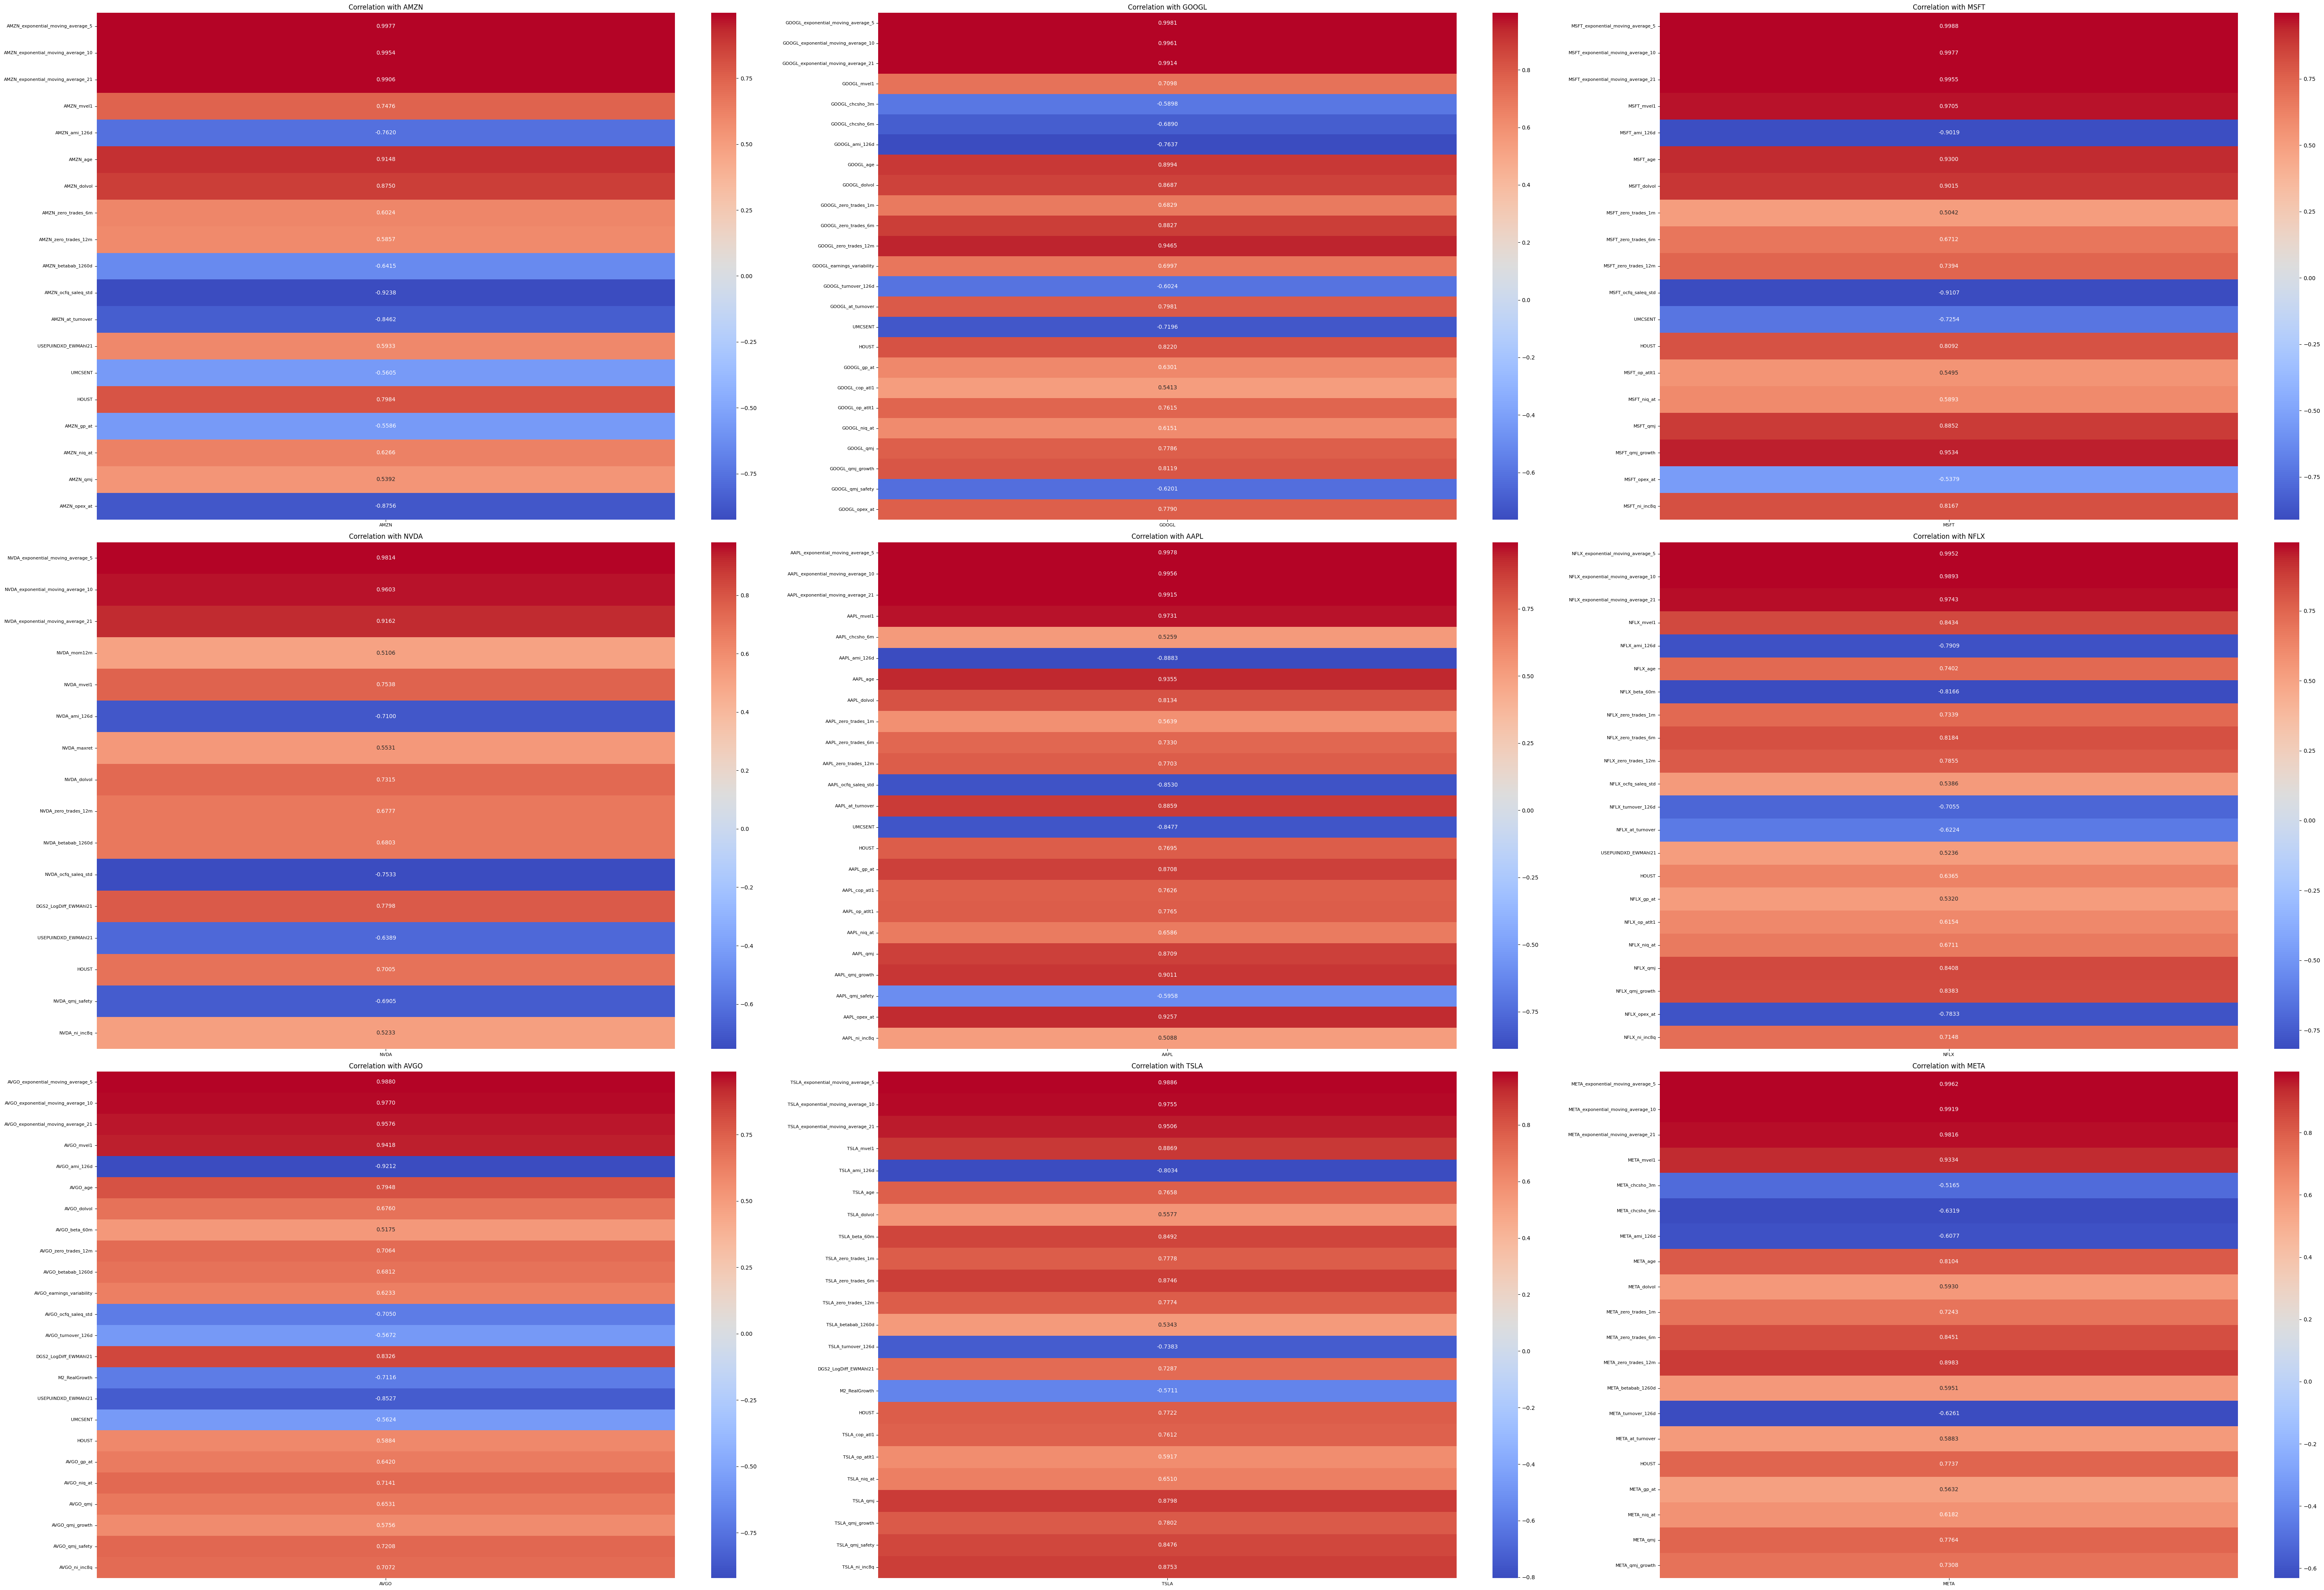

In [3]:
def plot_corr_matrix_with_specific_column(data_df, column_name, ax):
    CorrMatrix = data_df.corr()
    column_corr = CorrMatrix[[f"{column_name}"]]

    # Apply the threshold filter so that correlations not above 0.5 or below -0.5 become NaN
    column_corr = column_corr.where((column_corr >= 0.5) | (column_corr <= -0.5))

    # Exclude self-correlation
    column_corr = column_corr.drop(index=column_name)

    # Remove rows that became all NaN after filtering
    column_corr = column_corr.dropna(how='all')

    sns.heatmap(column_corr, annot=True, fmt='.4f', cmap='coolwarm', cbar=True, ax=ax)
    ax.set_title(f'Correlation with {column_name}', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    return column_corr.index

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(60, 40))
axes = axes.flatten()

for i, (key, value) in enumerate(training_stock_df.items()):
    if i < len(axes):
        stock = key.split("_")[0]
        selected_feature = plot_corr_matrix_with_specific_column(value, stock, axes[i])

        # Store the selected features in the feature_counter
        for feature in selected_feature:
            feature_counter[stock][feature] += 1

plt.tight_layout()
plt.show()

### Method 2: Recursive Feature Elimination (RFE)

In [4]:
for stock in stock_list:
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=24)
    fit = rfe.fit(training_stock_df[stock].drop(columns=[stock]), training_stock_df[stock][stock].values.ravel())
    selected_features_rfe = training_stock_df[stock].drop(columns=[stock]).columns[fit.support_]

    # Store the selected features in the feature_counter
    for feature in selected_features_rfe:
        feature_counter[stock][feature] += 1

    print(f"Stock: {stock}")
    print("Selected Features:", selected_features_rfe)
    print("--------------------------------------------------------")
    

Stock: AMZN
Selected Features: Index(['AMZN_sortino_ratio_5', 'AMZN_sortino_ratio_10',
       'AMZN_sortino_ratio_21', 'AMZN_mom1m', 'AMZN_rvol_21d',
       'AMZN_chcsho_1m', 'AMZN_chcsho_3m', 'AMZN_chcsho_6m', 'AMZN_ami_126d',
       'AMZN_maxret', 'AMZN_zero_trades_1m', 'AMZN_zero_trades_6m',
       'AMZN_zero_trades_12m', 'AMZN_ocfq_saleq_std', 'AMZN_turnover_126d',
       'AMZN_at_turnover', 'T_30', 'AMZN_VXN_LogDiff_EWMAhl63', 'CPI_ROC',
       'DGS2_LogDiff_EWMAhl21', 'AMZN_gp_at', 'AMZN_niq_at', 'AMZN_qmj',
       'AMZN_opex_at'],
      dtype='object')
--------------------------------------------------------
Stock: GOOGL
Selected Features: Index(['GOOGL_downside_deviation_5', 'GOOGL_downside_deviation_10',
       'GOOGL_downside_deviation_21', 'GOOGL_mom12m', 'GOOGL_mom1m',
       'GOOGL_rvol_21d', 'GOOGL_chcsho_1m', 'GOOGL_chcsho_6m',
       'GOOGL_ami_126d', 'GOOGL_zero_trades_1m', 'GOOGL_zero_trades_6m',
       'GOOGL_zero_trades_12m', 'GOOGL_ocfq_saleq_std', 'GOOGL_turnover_